In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import json
import string

In [2]:
# Create stemmer
stemmer = StemmerFactory().create_stemmer()

In [13]:
# Create Stopword
my_stop_words = StopWordRemoverFactory().get_stop_words()
f = open("Stopword.txt", "r")
stop = f.readlines()
f.close()
my_stop_words += stop
my_stop_words =  list(dict.fromkeys(my_stop_words))

In [4]:
# Preprocessor
def my_preprocessor(mytext):
    #Convert to lower case
    mytext = mytext.lower()
    #Remove additional code
    mytext = mytext.replace('\\xe2\\x80\\xa6', '')
    #Convert www.* or https?://* to URL
    mytext = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',mytext)
    #Convert @username to AT_USER
    mytext = re.sub('@[^\s]+','ATUSER',mytext)
    #Remove additional white spaces
    mytext = re.sub('[\s]+', ' ', mytext)
    #Replace #word with word
    mytext = re.sub(r'#([^\s]+)', r'\1',mytext)
    #Menghapus angka dari teks
    mytext = re.sub(r"\d+", "", mytext)
    #Menghapus tanda baca
    mytext = mytext.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    return mytext

In [5]:
# Tokenizer
def my_tokenizer(mytext):
    words = word_tokenize(mytext)
    tokens=[]
    for w in words:
        #add tokens
        if w not in ['ATUSER','URL'] and len(w) > 3:
            w = stemmer.stem(w)
            tokens.append(w.lower())
    return tokens

In [6]:
# Cleanner 
def cleaning(text):
    text= text[2:]
    text = text.replace('\\n',' ')
    return text

In [7]:
# Import data
data1 = pd.read_csv('Crawling Twitter Jakarta Baru 26 - 27.csv')
data2 = pd.read_csv('Crawling Twitter Jakarta Baru 25 - 23.csv')
data3 = pd.read_csv('Crawling Twitter Jakarta Baru 22 - 19 setengah.csv')
data_ = pd.concat([data1,data2,data3])
# Memilih kolom pada DataFrame untuk di olah
data = data_['Tweets'].tolist()

In [8]:
# Cleaning the Data
for i in range(len(data)):
    data[i] = cleaning(data[i])

In [27]:
#Defining Vectorizer
vectorizer_count = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer, stop_words=my_stop_words, min_df=5, max_df=0.85)
vectorizer_tfidf = TfidfVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer, stop_words=my_stop_words, min_df=5, max_df=0.85)

In [29]:
word_count = vectorizer_count.fit_transform(data)
word_tfidf = vectorizer_tfidf.fit_transform(data)

In [30]:
#Saving Model
import pickle
pickle.dump(word_count, open("word_count.pickle", "wb"))
pickle.dump(word_tfidf, open("word_tfidf.pickle", "wb"))
#Load Model
#model_word_count = pickle.load(open('word_count.pickle', 'rb'))
#model_word_tfidf = pickle.load(open('word_tfidf.pickle', 'rb'))

In [31]:
# Mapping from column index to feature name
nama_fitur = vectorizer_tfidf.get_feature_names()

In [32]:
# Get Dimension
dimensions = word_count.get_shape()
print("Jumlah artikel = %s" % dimensions[0])
print("Jumlah fitur = %s" % dimensions[1])

Jumlah artikel = 250279
Jumlah fitur = 12174


In [33]:
# Penentuan jumlah kata pada artikel terpanjang & terpendek (pada artikel yg telah dilakukan preprocessing & filtering)
jumlah_kata_per_artikel = word_count.sum(axis=1)
print("Jumlah kata pada artikel terpanjang = %s" % str(max(jumlah_kata_per_artikel)).strip('[]'))
print("Jumlah kata pada artikel terpendek = %s" % str(min(jumlah_kata_per_artikel)).strip('[]'))

Jumlah kata pada artikel terpanjang = 41
Jumlah kata pada artikel terpendek = 0


In [34]:
# Penentuan kata dengan bobot tfidf tertinggi pada setiap Tweet
print ("Memulai proses penentuan 10 kata dengan bobot tertinggi...")
content1 = []
content2 = []

Memulai proses penentuan 10 kata dengan bobot tertinggi...


In [35]:
for n in range(dimensions[0]):
    # Convert sparse matrix row by row 
    row = word_tfidf.getrow(n).toarray()[0].ravel()
    # Get top values and its indexes 
    top_ten_indices = row.argsort()[-1]
    top_ten_values = row[row.argsort()[-1]]
    # Identify the highest TFIDF value and word #
    highestTFIDFword = nama_fitur[top_ten_indices]
    highestTFIDFvalue = top_ten_values
    top1word = {'nomor artikel': n+1, 'nilai TFIDF': highestTFIDFvalue,'top word':highestTFIDFword}
    content1.append(top1word)
    content2.append(highestTFIDFword)

In [36]:
# Menghitung Frekuiensi kata dengan bobot terbesar tiap tweetnya
content2 = np.array(content2)
words, n = np.unique(content2, return_counts=True)

In [37]:
# Convert to DataFrame agar lebih mudah dalam mengurutkan
data = pd.DataFrame()
data['Kata'] = words
data['Banyak'] = n
data = data.sort_values(by='Banyak', ascending=False)
# Memilih kata dengan frekuensi lebih dari 110 saja
data = data.head(20)

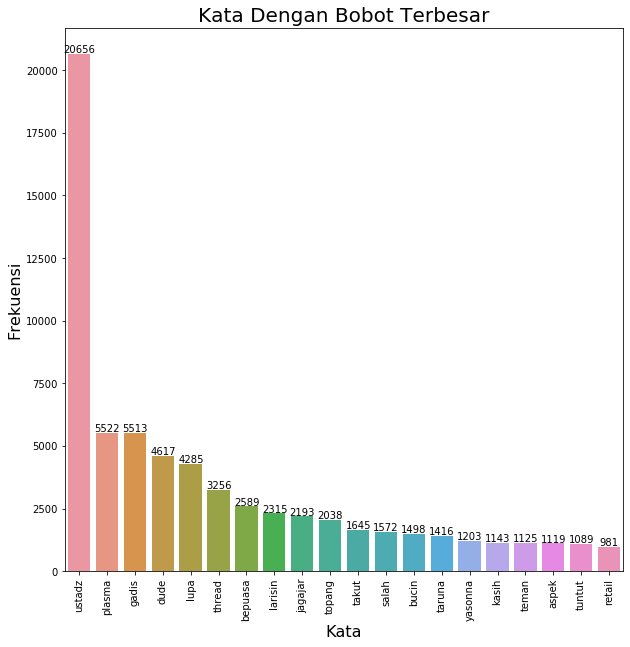

In [41]:
# Plotting Barplot
plt.figure(figsize = (10,10))
sns.barplot(x = data['Kata'],y = data['Banyak'])
for i, v in enumerate(data['Banyak'].tolist()):
    plt.text(i-len(str(v))/10-.05, v + 50, str(v),fontsize=10)
plt.title('Kata Dengan Bobot Terbesar',fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Kata',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.show()

In [39]:
# Merekam kata dengan nilai TFIDF tertinggi pada setiap artikel
filetarget1 = 'Top_word_Twitter.json'
with open(filetarget1, 'w') as file_object1:
    json.dump(content1, file_object1)

file_object1.close()

Prosess telah selesai!


In [45]:
#Loading Sample tweet sentiment
sample = pd.read_csv('Sample Tweet.csv')
sample.head()

,Index,Tweets,Sentiment
0,51365,b'Salut! Polri mendapat apresiasi dari DPR RI ...,1
1,94963,b'Sebelum booming corona biasanya ke pasar non...,-1
2,16832,b'Covid 19 plus 30 ribu narapidana https://t.c...,-1
3,29905,"b'@faruqhmd Lu corona ora, muntaber iya.'",-1
4,25279,b'3. Jenazah belum dapat dipastikan apakah pos...,0


In [47]:
#Marging data utama dengan data sampel berdasarkan kolom sentiment
Data = pd.merge(data_,sample[['Tweets','Sentiment']],on='Tweets',how='left')
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250279 entries, 0 to 250278
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Tanggal         250279 non-null  object 
 1   Tweets          250279 non-null  object 
 2   ID              250279 non-null  int64  
 3   Screen Name     250279 non-null  object 
 4   Banyak Retweet  250279 non-null  int64  
 5   Source          250277 non-null  object 
 6   Retweet Status  250279 non-null  int64  
 7   Hashtags        250279 non-null  object 
 8   Sentiment       1583 non-null    float64
dtypes: float64(1), int64(3), object(5)
memory usage: 19.1+ MB


In [62]:
#Defining X & Y
X = word_tfidf[Data.index[pd.notna(Data['Sentiment'])]]
Y = Data['Sentiment'][pd.notna(Data['Sentiment'])]

In [63]:
#Split training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics

names = ["Logistic Regression     ", "Random Forest Classifier", "Decision Tree Classifier"]
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    DecisionTreeClassifier()
    ]

#Train the model using the training sets y_pred=clf.predict(X_test)
for i in range(len(names)):
    clf = classifiers[i].fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(f"Accuracy {names[i]} : ",metrics.accuracy_score(y_test, y_pred))

Accuracy Logistic Regression      :  0.8336842105263158
Accuracy Random Forest Classifier :  0.8315789473684211
Accuracy Decision Tree Classifier :  0.791578947368421


In [77]:
#Memprediksi menggunakan Logistic Regression
clf = LogisticRegression().fit(X_train,y_train)
test = word_tfidf[Data.index[Data['Sentiment'].isna()]]
Data['Sentiment'][Data['Sentiment'].isna()] = clf.predict(test)

In [83]:
#Checking data
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250279 entries, 0 to 250278
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Tanggal         250279 non-null  object
 1   Tweets          250279 non-null  object
 2   ID              250279 non-null  int64 
 3   Screen Name     250279 non-null  object
 4   Banyak Retweet  250279 non-null  int64 
 5   Source          250277 non-null  object
 6   Retweet Status  250279 non-null  int64 
 7   Hashtags        250279 non-null  object
 8   Sentiment       250279 non-null  int32 
dtypes: int32(1), int64(3), object(5)
memory usage: 28.1+ MB


In [82]:
Data['Sentiment'] = Data['Sentiment'].astype('int')

In [84]:
# Export data baru
Data.to_csv('Data Sentiment Twitter 19 - 27 April.csv',index=False)

In [89]:
#EDA
sentimen = Data['Tweets'].groupby(Data['Sentiment']).count()
temp = sentimen.values

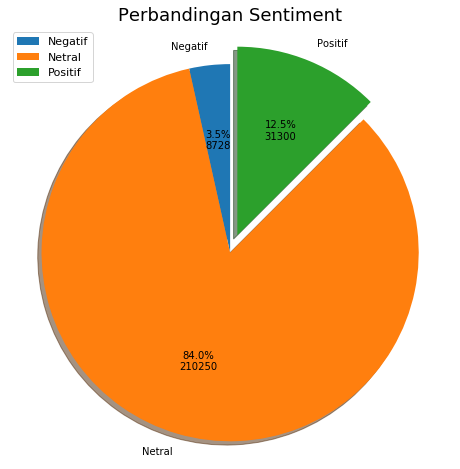

In [95]:
#Plotting Pie
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n{:d}".format(pct, absolute)

plt.figure(figsize = (8,8))
plt.pie(temp,explode=(0,0,0.1),labels=['Negatif','Netral','Positif'],shadow=True,
        autopct=lambda pct: func(pct, temp),startangle=90)
plt.title('Perbandingan Sentiment',fontsize=18)
plt.axis('equal')
plt.legend(fontsize=11)
plt.show()

In [122]:
#Melihat banyak Tweet perhari
Data['Tanggal'] = pd.to_datetime(Data['Tanggal'])
tph = Data['Tweets'].groupby([Data['Tanggal'].dt.date,Data['Sentiment']]).count()
frek = tph.values

In [130]:
tanggal = [ i for i, j in tph.index.tolist() ]
senti = [ j for i, j in tph.index.tolist() ]
sent = pd.DataFrame({'Tanggal':tanggal,'Sentiment':senti,'Frekuensi':frek})

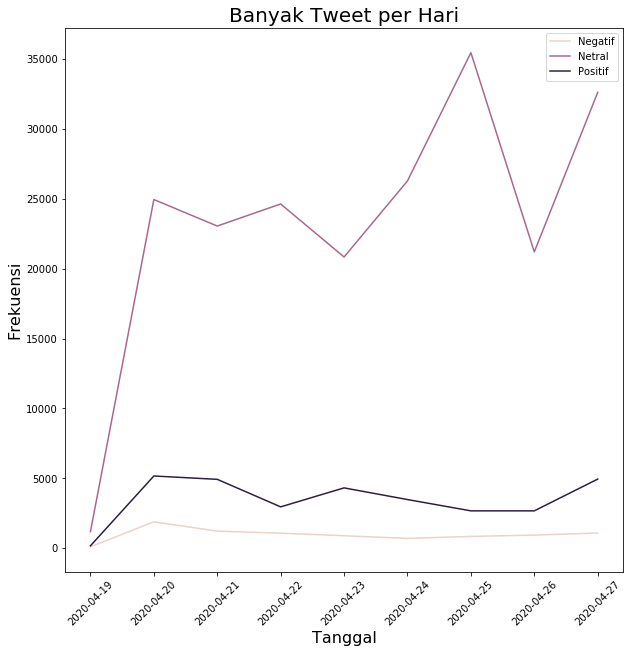

In [138]:
plt.figure(figsize = (10,10))
sns.lineplot(x='Tanggal',y='Frekuensi',hue='Sentiment',data=sent)
plt.title('Banyak Tweet per Hari',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Tanggal',fontsize=16)
plt.ylabel('Frekuensi',fontsize=16)
plt.legend(['Negatif','Netral','Positif'])
plt.show()

In [ ]:
#Selesai
#Terima Kasih